# Required imports

In [1]:
import torch
import torchmetrics
import wandb

import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from review_classifier import ReviewClassifier

# Logging into Weights&Biases

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dominika-boguszewska-stud (dominika-boguszewska-stud-warsaw-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Loading data

In [3]:
dataset = load_dataset("Yelp/yelp_review_full")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

## Splitting data into training, validation and testing datasets

In [5]:
test_dataset = dataset["test"]

split_dataset = dataset["train"].train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

In [6]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['label', 'text'],
    num_rows: 520000
})
Dataset({
    features: ['label', 'text'],
    num_rows: 130000
})
Dataset({
    features: ['label', 'text'],
    num_rows: 50000
})


In [7]:
print(train_dataset[0])

{'label': 3, 'text': 'One of our favorite Madison restaurants!  Great food (most of the time) and fast.  The non-booth side feels like a cafeteria, though, since the tables are so close together.  Great desserts too!'}


## Creating smaller subsets

In [8]:
train_dataset = train_dataset.shuffle().select(range(int(len(train_dataset) * .15)))
val_dataset = val_dataset.shuffle().select(range(int(len(val_dataset) * .1)))
test_dataset = test_dataset.shuffle().select(range(int(len(test_dataset) * .4)))

print(f"Number of samples in training set: {len(train_dataset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")
print(f"Number of samples in testing set: {len(test_dataset)}")

Number of samples in training set: 78000
Number of samples in validation set: 13000
Number of samples in testing set: 20000


## Histogram of labels in training dataset

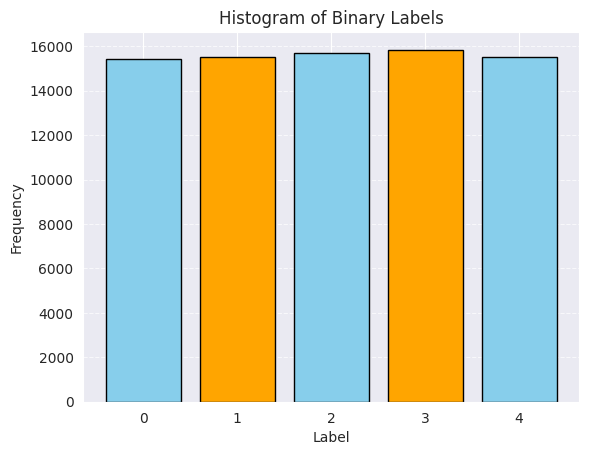

In [9]:
# Count occurrences of each label
unique_labels, counts = np.unique(train_dataset['label'], return_counts=True)

# Plot histogram
plt.bar(unique_labels, counts, color=['skyblue', 'orange'], edgecolor='black')
plt.title('Histogram of Binary Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# TF-IDF Feature Extraction

In [10]:
vocab_size = 10000

vectorizer = TfidfVectorizer(
    max_features=vocab_size,
    lowercase=True,
    analyzer='word',
    ngram_range=(1, 1),
    stop_words="english"
)

train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
val_tfidf_features = vectorizer.transform(val_dataset["text"])
test_tfidf_features = vectorizer.transform(test_dataset["text"])

In [11]:
print(f"Size of TF-IDF matrix for training dataset: {train_tfidf_features.shape}")
print(f"{train_tfidf_features.dtype=}\n")

feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Example features: {np.random.choice(feature_names, 20)}\n")

Size of TF-IDF matrix for training dataset: (78000, 10000)
train_tfidf_features.dtype=dtype('float64')

Number of features: 10000
Example features: ['laid' 'stopping' 'sicilian' 'carried' 'suggested' 'flawless' 'catherine'
 'san' 'meet' 'stumbled' 'dreams' 'finish' 'hubs' 'amenities' 'expansive'
 'wir' 'greasy' 'fitting' 'nwas' 'tamale']



## Displaying the feature vector for the selected training set element

In [12]:
ndx = 111
print(f"Training set element with index={ndx}")
print(f"{train_dataset['text'][ndx]=}\n")

print(f"Features of element with index={ndx}:")

features = train_tfidf_features[ndx]
non_zero_cols = features.nonzero()[1]

non_zero_cols = sorted(non_zero_cols)

for i in non_zero_cols:
    print(f"Column: {i} ({feature_names[i]})   Weight: {features[0, i]:.5f}")

Training set element with index=111
train_dataset['text'][ndx]='Jacs has got the atmosphere nailed - love the wood floors, exposed brick walls and tin ceilings. Our server was excellent - friendly, attentive, and knowledgeable about the  menu.  \\n\\nWe started with an order of cheese curds which carried a $7 price tag. We were both left us going \\"wah wah\\" when a small plate arrived, the cheese curds barely making up a layer covering the plate. Good thing I\'m not too much of a cheese curd lover because this was hardly a Wisconsin portion for two! (I\'m from Michigan, forgive me, I don\'t know any better...)\\n\\nThe draft beer list is extensive and diverse, although it is pricey. Most of the beers are in the $7-8 range.  I certainly understand that fancy beers are often served in a smaller goblet glass, but I do think a menu should (and usually does) indicate this in the description.  Otherwise you get sad thirsty people like me expecting a pint and getting a tulip.  \\n\\nMoving 

# Converting datasets into DataLoader

In [13]:
def make_dataset(sparse_features, labels):
    dense_features = sparse_features.astype(np.float32).todense()

    dataset = TensorDataset(
        torch.from_numpy(dense_features),
        torch.tensor(labels, dtype=torch.int64)
    )

    return dataset

In [14]:
datasets = {
    'train': make_dataset(train_tfidf_features, train_dataset['label']),
    'val': make_dataset(val_tfidf_features, val_dataset['label']),
    'test': make_dataset(test_tfidf_features, test_dataset['label'])
}

In [15]:
batch_size = 256

dataloaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=split=='train', num_workers=0) for split in datasets}

# Creating instance of ReviewClassifier model

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Urządzenie: {}".format(device))

Urządzenie: cuda:0


In [17]:
classifier = ReviewClassifier(vocab_size, n_classes=5)
classifier.to(device)

print(classifier)

ReviewClassifier(
  (feature_extractor): Sequential(
    (0): Linear(in_features=10000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=16, out_features=5, bias=True)
)


# Training

In [18]:
def train(
        model: nn.Module,
        loaders: dict[DataLoader],
        criterion: nn.Module,
        optimizer: torch.optim.Optimizer,
        lr_scheduler,
        num_epochs: int
):

    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass",num_classes=5).to(device)

    for epoch in range(1, num_epochs+1):

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            for X_batch, target in tqdm(loaders[phase]):
                X_batch, target = X_batch.to(device), target.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)

                    loss = criterion(logits, target)

                    metric_loss(loss)
                    metric_acc(preds, target)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            acc = metric_acc.compute()
            mean_loss = metric_loss.compute()
            current_lr = lr_scheduler.get_last_lr()[0]

            print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {acc:.3f}   lr: {current_lr}")

            metrics = {
                f"{phase}/loss": mean_loss,
                f"{phase}/accuracy": acc,
                f"{phase}/lr": current_lr,
            }

            wandb.log(metrics, step=epoch)

            metric_loss.reset()
            metric_acc.reset()

        lr_scheduler.step()


In [19]:
num_epochs = 30

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    classifier.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,
    eta_min=1e-5
)

run = wandb.init(project="Yelp_Review_Rating_Predictor")
train(classifier, dataloaders, criterion, optimizer, lr_scheduler, num_epochs)
run.finish()

100%|██████████| 305/305 [00:02<00:00, 134.50it/s]


(Epoch 1/[train]) Loss:	1.610   Accuracy: 0.239   lr: 0.0001


100%|██████████| 51/51 [00:00<00:00, 175.46it/s]


(Epoch 1/[val]) Loss:	1.590   Accuracy: 0.298   lr: 0.0001


100%|██████████| 305/305 [00:02<00:00, 151.71it/s]


(Epoch 2/[train]) Loss:	1.550   Accuracy: 0.324   lr: 9.97534852915723e-05


100%|██████████| 51/51 [00:00<00:00, 182.49it/s]


(Epoch 2/[val]) Loss:	1.500   Accuracy: 0.358   lr: 9.97534852915723e-05


100%|██████████| 305/305 [00:01<00:00, 155.95it/s]


(Epoch 3/[train]) Loss:	1.433   Accuracy: 0.395   lr: 9.901664203302126e-05


100%|██████████| 51/51 [00:00<00:00, 171.82it/s]


(Epoch 3/[val]) Loss:	1.366   Accuracy: 0.411   lr: 9.901664203302126e-05


100%|██████████| 305/305 [00:02<00:00, 149.18it/s]


(Epoch 4/[train]) Loss:	1.305   Accuracy: 0.412   lr: 9.779754323328192e-05


100%|██████████| 51/51 [00:00<00:00, 132.09it/s]


(Epoch 4/[val]) Loss:	1.251   Accuracy: 0.434   lr: 9.779754323328192e-05


100%|██████████| 305/305 [00:02<00:00, 117.98it/s]


(Epoch 5/[train]) Loss:	1.211   Accuracy: 0.481   lr: 9.610954559391703e-05


100%|██████████| 51/51 [00:00<00:00, 170.72it/s]


(Epoch 5/[val]) Loss:	1.175   Accuracy: 0.532   lr: 9.610954559391703e-05


100%|██████████| 305/305 [00:02<00:00, 140.14it/s]


(Epoch 6/[train]) Loss:	1.148   Accuracy: 0.517   lr: 9.397114317029975e-05


100%|██████████| 51/51 [00:00<00:00, 171.89it/s]


(Epoch 6/[val]) Loss:	1.122   Accuracy: 0.541   lr: 9.397114317029975e-05


100%|██████████| 305/305 [00:02<00:00, 152.04it/s]


(Epoch 7/[train]) Loss:	1.097   Accuracy: 0.533   lr: 9.140576474687265e-05


100%|██████████| 51/51 [00:00<00:00, 172.60it/s]


(Epoch 7/[val]) Loss:	1.080   Accuracy: 0.546   lr: 9.140576474687265e-05


100%|██████████| 305/305 [00:02<00:00, 141.31it/s]


(Epoch 8/[train]) Loss:	1.059   Accuracy: 0.541   lr: 8.844151714648274e-05


100%|██████████| 51/51 [00:00<00:00, 131.80it/s]


(Epoch 8/[val]) Loss:	1.050   Accuracy: 0.552   lr: 8.844151714648274e-05


100%|██████████| 305/305 [00:02<00:00, 121.15it/s]


(Epoch 9/[train]) Loss:	1.030   Accuracy: 0.550   lr: 8.511087728614862e-05


100%|██████████| 51/51 [00:00<00:00, 172.10it/s]


(Epoch 9/[val]) Loss:	1.030   Accuracy: 0.554   lr: 8.511087728614862e-05


100%|██████████| 305/305 [00:02<00:00, 148.32it/s]


(Epoch 10/[train]) Loss:	1.007   Accuracy: 0.559   lr: 8.14503363531613e-05


100%|██████████| 51/51 [00:00<00:00, 176.41it/s]


(Epoch 10/[val]) Loss:	1.017   Accuracy: 0.557   lr: 8.14503363531613e-05


100%|██████████| 305/305 [00:01<00:00, 152.74it/s]


(Epoch 11/[train]) Loss:	0.990   Accuracy: 0.565   lr: 7.75e-05


100%|██████████| 51/51 [00:00<00:00, 167.98it/s]


(Epoch 11/[val]) Loss:	1.008   Accuracy: 0.558   lr: 7.75e-05


100%|██████████| 305/305 [00:02<00:00, 137.36it/s]


(Epoch 12/[train]) Loss:	0.977   Accuracy: 0.571   lr: 7.330314893841101e-05


100%|██████████| 51/51 [00:00<00:00, 174.77it/s]


(Epoch 12/[val]) Loss:	1.003   Accuracy: 0.559   lr: 7.330314893841101e-05


100%|██████████| 305/305 [00:02<00:00, 149.98it/s]


(Epoch 13/[train]) Loss:	0.966   Accuracy: 0.576   lr: 6.890576474687264e-05


100%|██████████| 51/51 [00:00<00:00, 174.32it/s]


(Epoch 13/[val]) Loss:	0.999   Accuracy: 0.560   lr: 6.890576474687264e-05


100%|██████████| 305/305 [00:02<00:00, 149.00it/s]


(Epoch 14/[train]) Loss:	0.957   Accuracy: 0.579   lr: 6.435602608679918e-05


100%|██████████| 51/51 [00:00<00:00, 173.94it/s]


(Epoch 14/[val]) Loss:	0.996   Accuracy: 0.561   lr: 6.435602608679918e-05


100%|██████████| 305/305 [00:01<00:00, 153.89it/s]


(Epoch 15/[train]) Loss:	0.950   Accuracy: 0.584   lr: 5.970378084704442e-05


100%|██████████| 51/51 [00:00<00:00, 176.60it/s]


(Epoch 15/[val]) Loss:	0.994   Accuracy: 0.561   lr: 5.970378084704442e-05


100%|██████████| 305/305 [00:02<00:00, 148.16it/s]


(Epoch 16/[train]) Loss:	0.943   Accuracy: 0.587   lr: 5.500000000000002e-05


100%|██████████| 51/51 [00:00<00:00, 154.14it/s]


(Epoch 16/[val]) Loss:	0.993   Accuracy: 0.562   lr: 5.500000000000002e-05


100%|██████████| 305/305 [00:02<00:00, 119.99it/s]


(Epoch 17/[train]) Loss:	0.939   Accuracy: 0.590   lr: 5.029621915295561e-05


100%|██████████| 51/51 [00:00<00:00, 124.93it/s]


(Epoch 17/[val]) Loss:	0.992   Accuracy: 0.562   lr: 5.029621915295561e-05


100%|██████████| 305/305 [00:02<00:00, 149.46it/s]


(Epoch 18/[train]) Loss:	0.934   Accuracy: 0.592   lr: 4.5643973913200835e-05


100%|██████████| 51/51 [00:00<00:00, 110.63it/s]


(Epoch 18/[val]) Loss:	0.992   Accuracy: 0.562   lr: 4.5643973913200835e-05


100%|██████████| 305/305 [00:02<00:00, 147.48it/s]


(Epoch 19/[train]) Loss:	0.930   Accuracy: 0.593   lr: 4.109423525312738e-05


100%|██████████| 51/51 [00:00<00:00, 175.19it/s]


(Epoch 19/[val]) Loss:	0.992   Accuracy: 0.562   lr: 4.109423525312738e-05


100%|██████████| 305/305 [00:02<00:00, 147.00it/s]


(Epoch 20/[train]) Loss:	0.928   Accuracy: 0.595   lr: 3.669685106158901e-05


100%|██████████| 51/51 [00:00<00:00, 127.90it/s]


(Epoch 20/[val]) Loss:	0.992   Accuracy: 0.562   lr: 3.669685106158901e-05


100%|██████████| 305/305 [00:02<00:00, 118.95it/s]


(Epoch 21/[train]) Loss:	0.923   Accuracy: 0.598   lr: 3.250000000000002e-05


100%|██████████| 51/51 [00:00<00:00, 164.44it/s]


(Epoch 21/[val]) Loss:	0.992   Accuracy: 0.562   lr: 3.250000000000002e-05


100%|██████████| 305/305 [00:02<00:00, 151.33it/s]


(Epoch 22/[train]) Loss:	0.921   Accuracy: 0.599   lr: 2.8549663646838724e-05


100%|██████████| 51/51 [00:00<00:00, 177.20it/s]


(Epoch 22/[val]) Loss:	0.992   Accuracy: 0.561   lr: 2.8549663646838724e-05


100%|██████████| 305/305 [00:02<00:00, 150.86it/s]


(Epoch 23/[train]) Loss:	0.919   Accuracy: 0.599   lr: 2.4889122713851404e-05


100%|██████████| 51/51 [00:00<00:00, 178.27it/s]


(Epoch 23/[val]) Loss:	0.992   Accuracy: 0.562   lr: 2.4889122713851404e-05


100%|██████████| 305/305 [00:02<00:00, 149.04it/s]


(Epoch 24/[train]) Loss:	0.918   Accuracy: 0.601   lr: 2.1558482853517277e-05


100%|██████████| 51/51 [00:00<00:00, 160.69it/s]


(Epoch 24/[val]) Loss:	0.992   Accuracy: 0.562   lr: 2.1558482853517277e-05


100%|██████████| 305/305 [00:02<00:00, 137.72it/s]


(Epoch 25/[train]) Loss:	0.917   Accuracy: 0.601   lr: 1.8594235253127375e-05


100%|██████████| 51/51 [00:00<00:00, 180.69it/s]


(Epoch 25/[val]) Loss:	0.992   Accuracy: 0.561   lr: 1.8594235253127375e-05


100%|██████████| 305/305 [00:02<00:00, 149.99it/s]


(Epoch 26/[train]) Loss:	0.914   Accuracy: 0.601   lr: 1.6028856829700262e-05


100%|██████████| 51/51 [00:00<00:00, 174.51it/s]


(Epoch 26/[val]) Loss:	0.992   Accuracy: 0.562   lr: 1.6028856829700262e-05


100%|██████████| 305/305 [00:02<00:00, 151.32it/s]


(Epoch 27/[train]) Loss:	0.914   Accuracy: 0.603   lr: 1.389045440608296e-05


100%|██████████| 51/51 [00:00<00:00, 177.62it/s]


(Epoch 27/[val]) Loss:	0.992   Accuracy: 0.561   lr: 1.389045440608296e-05


100%|██████████| 305/305 [00:02<00:00, 149.77it/s]


(Epoch 28/[train]) Loss:	0.912   Accuracy: 0.603   lr: 1.2202456766718093e-05


100%|██████████| 51/51 [00:00<00:00, 174.98it/s]


(Epoch 28/[val]) Loss:	0.993   Accuracy: 0.561   lr: 1.2202456766718093e-05


100%|██████████| 305/305 [00:02<00:00, 121.33it/s]


(Epoch 29/[train]) Loss:	0.913   Accuracy: 0.603   lr: 1.0983357966978745e-05


100%|██████████| 51/51 [00:00<00:00, 135.68it/s]


(Epoch 29/[val]) Loss:	0.993   Accuracy: 0.561   lr: 1.0983357966978745e-05


100%|██████████| 305/305 [00:02<00:00, 145.67it/s]


(Epoch 30/[train]) Loss:	0.912   Accuracy: 0.603   lr: 1.0246514708427697e-05


100%|██████████| 51/51 [00:00<00:00, 177.77it/s]

(Epoch 30/[val]) Loss:	0.993   Accuracy: 0.561   lr: 1.0246514708427697e-05


train/accuracy,▁▃▄▄▆▆▇▇▇▇▇▇▇█████████████████
train/loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,██████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
val/accuracy,▁▃▄▅▇▇████████████████████████
val/loss,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/lr,██████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train/accuracy,0.6031
train/loss,0.91191
train/lr,1e-05
val/accuracy,0.56108
val/loss,0.99282


# Model evaluation

## Getting predictions

In [20]:
preds_l = []
targets_l = []

classifier.eval()

for X_batch, target in tqdm(dataloaders['test']):
    # Przenieś dane na odpowiednie urządzenie
    X_batch, target = X_batch.to(device), target.to(device)

    # Przejście w przód (forward)
    # Śledzenie historii obliczeń tylko w fazie trenowania
    with torch.inference_mode():
        logits = classifier(X_batch)
        _, preds = torch.max(logits, dim=-1)
        preds_l.extend(preds.cpu().numpy())
        targets_l.extend(target.cpu().numpy())

preds = np.array(preds_l)
targets = np.array(targets_l)

print(f"{preds.shape=}")
print(f"{targets.shape=}")

100%|██████████| 79/79 [00:00<00:00, 228.66it/s]

preds.shape=(20000,)
targets.shape=(20000,)


## Calculating metrics

In [21]:
labels = ['0', '1', '2', '3', '4']

report = classification_report(targets, preds, target_names = labels)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.75      0.71      3891
           1       0.50      0.49      0.49      3975
           2       0.48      0.42      0.45      4102
           3       0.49      0.48      0.48      4026
           4       0.65      0.69      0.67      4006

    accuracy                           0.56     20000
   macro avg       0.56      0.57      0.56     20000
weighted avg       0.56      0.56      0.56     20000



## Calculating confusion matrix

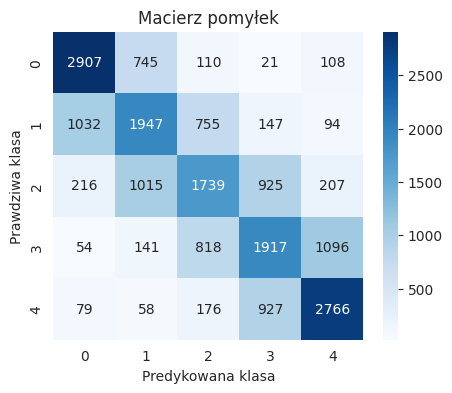

In [22]:
cm = confusion_matrix(targets, preds)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()